In [1]:
#experiment name and snapshot folder (used for model persistence)
experiment_setup_name = "tutorial.wikicat.advanced.sessions-debug"
snapshot_path = "/home/jheuristic/yozhik/agentnet_snapshots/"

In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


#theano imports
#the problem is too simple to be run on GPU. Seriously.
%env THEANO_FLAGS='device=cpu'
import theano
import theano.tensor as T
floatX = theano.config.floatX

import lasagne


env: THEANO_FLAGS='device=cpu'


In [3]:
%load_ext autoreload
%autoreload 2

# Why
This notebook aims to reproduce the advanced tutorial with training on sessions immedeately after they are created - instead of training on actual examples.

The expected learning curve is similar to one from advanced tutorial

# Experiment setup
* Here we load an experiment environment (description below)
* Designing one from scratch is explained in later tutorials

In [4]:
import agentnet.experiments.wikicat as experiment
print experiment.__doc__


This experiment Wikipedia data sample on musicians, scraped via the scripts present in this directory. 
For each musician, we know a number of boolean features (factors) on various topics like 
 * whether or not he/she was active in 1990's, 2000's, etc.
 * whether or not he/she plays guitar, piano, etc
 * whether or not he/she was born in 50's, 60's, etc.
 * what wikipedia categories does he/she belong to
 etc.



In the initial moment of time, agent knows nothing about any of them.
At each turn, agent may decide to
 - "open" one of the hidden factors.
   - if the factor turns out to be 1, agent receives +3 reward for Wikipedia categories, +1 for other categories,
   - Otherwise, the reward equals -1 for Wikipedia categories, -1 for other categores
   - all these rewards are parameterisable during environment creation
 - decide to quit session
   - yields reward of 0 and ends the interaction.
   - all farther actions will have no effect until next session

It is expected, that in orde

In [5]:
#Create an environment with all default parameters
env = experiment.WikicatEnvironment()

In [6]:
from sklearn.cross_validation import train_test_split
attrs, categories, feature_names = env.get_dataset(experiment_path="")

train_attrs,test_attrs,train_cats,test_cats = train_test_split(attrs,categories,test_size=0.99,random_state=32)

print "train size:", train_attrs.shape,train_cats.shape
print "train size:", test_attrs.shape,test_cats.shape

print "features:",feature_names[::20]

train size: (85, 300) (85, 93)
train size: (8509, 300) (8509, 93)
features: ['Children:is_known', 'Instruments:vocals', 'Genres:electronic', 'Origin:scotland', 'Genres:jazz', 'Genres:electric', 'Occupation:bassist', 'Instruments:violin', 'Genres:instrumental', 'Occupation:entrepreneur', 'Instruments:mandolin', 'Instruments:vocalist', 'Genres:synthpop', 'decades_active:1990', 'Occupation:remixer', 'category:List_of_musical_artists_from_Japan', 'category:List_of_ambient_music_artists', 'category:List_of_crooners', 'category:List_of_country_music_performers', 'category:List_of_bass_guitarists']


In [7]:
env.load_random_batch(train_attrs,train_cats,5)

In [8]:
import agentnet
s_env = agentnet.environment.SessionPoolEnvironment()

# agent setup
* An agent implementation has to contain three parts:
 * Memory layer(s)
  * in this case, we train two GRU layers [details below]
 * Q-values evaluation layers
  * in this case, a lasagne dense layer based on memory layer
 * Resolver - acton picker layer
  * in this case, the resolver has epsilon-greedy policy
  
  
### two-layer memory architecture
We train two memory states:
  * first one, based on observations,
  * second one, based on first one;

Note that here we update the second memory layer based on the CURRENT state
of the first one. Instead, you can try to feed it with a previous state.

The q-values are estimated on a concatenated state, effectively on both memory
states together, but there is no problem with limiting q-evaluator to only one:
just pass the correct gru layer as an incoming layer to the q-evaluator.

### Implementation:
We concatenate both memories into 1 state to pass it through the session loop.

To perform memory update, we need to slice the concatenated state back into
two memory states.

We do so by defining an input map function and passing it into agent.

We than concatenate two new states back to form a new memory state.



In [9]:
from agentnet.resolver import EpsilonGreedyResolver
from agentnet.memory import GRUMemoryLayer
from agentnet.agent import Agent

In [10]:
import lasagne
n_hid_1=128 #first GRU memory
n_hid_2=64 #second GRU memory


_observation_layer = lasagne.layers.InputLayer([None,env.observation_size],name="obs_input")

_prev_gru1_layer = lasagne.layers.InputLayer([None,n_hid_1],name="prev_gru1_state_input")
_prev_gru2_layer = lasagne.layers.InputLayer([None,n_hid_2],name="prev_gru2_state_input")

#memory
gru1 = GRUMemoryLayer(n_hid_1,
                     _observation_layer,
                     _prev_gru1_layer,
                     name="gru1")

gru2 = GRUMemoryLayer(n_hid_2,
                     gru1,        #note that it takes CURRENT gru1 output as input.
                                  #replacing that with _prev_gru1_state would imply taking previous one.
                     _prev_gru2_layer,
                     name="gru2")

concatenated_memory = lasagne.layers.concat([gru1,gru2])

#q_eval
n_actions = len(feature_names)
q_eval = lasagne.layers.DenseLayer(concatenated_memory, #taking both memories. 
                                                        #Replacing with gru1 or gru2 would mean taking one
                                   num_units = n_actions,
                                   nonlinearity=lasagne.nonlinearities.linear,name="QEvaluator")
#resolver
epsilon = theano.shared(np.float32(0.9),"e-greedy.epsilon")

resolver = EpsilonGreedyResolver(q_eval,epsilon=epsilon,name="resolver")



#we need to define the new input map because concatenated_memory is a ConcatLayer and does not have default one

def custom_input_map(last_hidden,observation):
    """just a function that maps memory states to respective inputs"""
    return {
        _prev_gru1_layer:last_hidden[:,0:n_hid_1],
        _prev_gru2_layer:last_hidden[:,n_hid_1:n_hid_1+n_hid_2],
        _observation_layer:observation
    }

#all together
agent = Agent(concatenated_memory,q_eval,resolver,input_map=custom_input_map
             )


In [11]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(resolver,trainable=True)
weights

[gru1.W_in_to_updategate,
 gru1.W_hid_to_updategate,
 gru1.b_updategate,
 gru1.W_in_to_resetgate,
 gru1.W_hid_to_resetgate,
 gru1.b_resetgate,
 gru1.W_in_to_hidden_update,
 gru1.W_hid_to_hidden_update,
 gru1.b_hidden_update,
 gru2.W_in_to_updategate,
 gru2.W_hid_to_updategate,
 gru2.b_updategate,
 gru2.W_in_to_resetgate,
 gru2.W_hid_to_resetgate,
 gru2.b_resetgate,
 gru2.W_in_to_hidden_update,
 gru2.W_hid_to_hidden_update,
 gru2.b_hidden_update,
 QEvaluator.W,
 QEvaluator.b]

## Agent setup in detail
* __Memory layers__
 * One-step recurrent layer
     * takes input and one's previous state
     * returns new memory state
   * Can be arbitrary lasagne layer
   * Several one-step recurrent units are implemented in __agentnet.memory__
   * Note that lasagne's default recurrent networks roll for several steps at once
     * in other words, __using lasagne recurrent units as memory means recurrence inside recurrence__
 * Using more than one memory layer is explained in farther tutorials


* __Q-values evaluation layer__
 * Can be arbitrary lasagne network
 * returns predicted Q-values for each action
 * Usually depends on memory as an input


* __Resolver__ - action picker
 * Decides on what action is taken
 * Normally takes Q-values as input
 * Currently all experiments require integer output
 * Several resolver layers are implemented in __agentnet.resolver__

# Interacting with environment
* an agent has a method that produces symbolic environment interaction sessions
* interactions result in sequences of observations, actions, q-values,etc
* one has to pre-define maximum session length.
 * in this case, environment implements an indicator of whether session has ended by current tick
* Since this environment also implements Objective methods, it can evaluate rewards for each [batch, time_tick]


In [12]:
#produce interaction sequences of length <= 10
history = agent.get_sessions(env,session_length=10,
                       batch_size=env.batch_size,)

state_seq,observation_seq,hidden_seq,qvalues_seq,action_seq = history

#get rewards for all actions
rewards_seq = env.get_reward_sequences(state_seq,action_seq)

#get indicator whether session is still active
is_alive_seq = env.get_whether_alive(observation_seq)


In [13]:

#Let us compile a function that returns all interaction logs
get_history = theano.function([],history+(is_alive_seq,rewards_seq,),mode=theano.compile.mode.FAST_RUN)



In [14]:

pool_loading = s_env.get_session_updates(observation_seq,action_seq,rewards_seq,is_alive_seq)
load_pool_fun = theano.function([],updates=pool_loading)


In [15]:
load_pool_fun()

[]

# Evaluating loss function
* This part is similar to the basic tutorial but for the fact that we use SARSA
 
 
 #### Get (prediction,reference) pairs

In [16]:
#produce interaction sequences of length <= 10
s_history = agent.get_sessions(s_env,session_length=10,
                       batch_size=s_env.pool_size,)

_,_,s_hidden_seq,s_qvalues_seq,_ = history

s_action_seq = s_env.actions
#get rewards for all actions
s_rewards_seq = s_env.rewards

#get indicator whether session is still active
s_is_alive_seq = s_env.is_alive


In [17]:
#get reference Qvalues according to Qlearning algorithm


from agentnet.learning import sarsa


#gamma - delayed reward coefficient - what fraction of reward is retained if it is obtained one tick later
gamma = theano.shared(np.float32(0.95),name = 'q_learning_gamma')


s_reference_Qvalues = sarsa.get_reference_Qvalues(s_qvalues_seq,
                               s_action_seq,
                               s_rewards_seq,
                               gamma_or_gammas=gamma,)

In [18]:
#zero-out future rewards at session end
from agentnet.utils.mdp import get_end_indicator

s_end_action_ids = get_end_indicator(s_is_alive_seq).nonzero()

# "set reference Qvalues at end action ids to just the immediate rewards"
s_reference_Qvalues = T.set_subtensor(s_reference_Qvalues[s_end_action_ids],
                                    s_rewards_seq[s_end_action_ids])

In [19]:
#prevent gradient updates over reference Qvalues (since they depend on predicted Qvalues)
from agentnet.utils import consider_constant
s_reference_Qvalues = consider_constant(s_reference_Qvalues)

In [20]:
from agentnet.utils.mdp import get_action_Qvalues
s_action_Qvalues = get_action_Qvalues(s_qvalues_seq,s_action_seq)

#### Define loss functions

In [21]:
#tensor of elementwise squared errors
squared_error = lasagne.objectives.squared_error(s_reference_Qvalues,s_action_Qvalues)

#zero-out ticks after session ended
squared_error = squared_error * s_is_alive_seq

#compute average of squared error sums per session
mse_loss = squared_error.sum() / s_is_alive_seq.sum()

In [22]:
#regularize network weights

from lasagne.regularization import regularize_network_params, l2
reg_l2 = regularize_network_params(resolver,l2)*10**-4

In [23]:
loss = mse_loss + reg_l2

#### Compute weight updates

In [24]:

updates = lasagne.updates.adadelta(loss,
                                             weights,learning_rate=0.05)

#### Some auxilary evaluation metrics

In [25]:
mean_session_reward = rewards_seq.sum(axis=1).mean()
#...

# Compile train and evaluation functions

In [26]:
train_fun = theano.function([],[loss,mean_session_reward],updates=updates)

evaluation_fun = theano.function([],[loss,mse_loss,reg_l2,mean_session_reward])

# session visualization tools


* this is a completely optional step of visualizing agent's sessions as chains of actions
* usually useful to get insight on what worked and what din't
* in this case, we print strings following pattern
  * [action_name] ([predicted action qvalue]) -> reward [reference qvalue] | next iteration

* plot shows
    * time ticks over X, abstract values over Y
    * bold lines are Qvalues for actions
    * dots on bold lines represent what actions were taken at each moment of time
    * dashed lines are agent's hidden state neurons
    * blue vertical line - session end
    
    
__Warning! the visualization tools are underdeveloped and only allow simple operations.__

if you found yourself struggling to make it do what you want for 5 minutes, go write your own tool [and contribute it :)]


In [34]:
s_hidden_seq.eval().shape

(3, 10, 192)

In [27]:
from agentnet.display.sessions import print_sessions
get_printables = theano.function([], [
        s_hidden_seq,s_qvalues_seq, s_action_seq,s_rewards_seq,s_reference_Qvalues,s_is_alive_seq
    ])

def display_sessions(with_plots = False):
        
    hidden_log,qvalues_log,actions_log,reward_log, reference_qv_log, is_alive_log = get_printables()
    
    
    print_sessions(qvalues_log,actions_log,reward_log,
                   is_alive_seq = is_alive_log,
                   #hidden_seq=hidden_log, #do not plot hidden since there's too many actions already
                   reference_policy_seq = reference_qv_log,
                   action_names=feature_names,
                   legend = False, #do not show legend since there's too many labeled objects
                  plot_policy = with_plots)

session # 0
 Genres:heavy(qv = 0.0) -> -1.0(ref = -0.984319865704) |  Occupation:bandleader(qv = 0.0165053904057) -> -1.0(ref = -0.979404687881) |  Political party:is_known(qv = 0.0216792505234) -> -1.0(ref = -0.967020869255) |  Label(s):is_known(qv = 0.0347148478031) -> -1.0(ref = -0.992758870125) |  Occupation:bandleader(qv = 0.00762226246297) -> -0.5(ref = -0.550539731979) |  category:List_of_gospel_musicians(qv = -0.0531997121871) -> -1.0(ref = -1.00993037224) |  Genres:contemporary(qv = -0.0104530416429) -> -1.0(ref = -0.990612387657) |  Other names:is_known(qv = 0.00988168176264) -> -1.0(ref = -1.0066267252) |  last_activity:1989(qv = -0.00697548501194) -> -1.0(ref = -0.911613941193) |  category:List_of_lead_guitarists(qv = 0.0930379554629) -> 0.0(ref = 0.0) | reached max session length


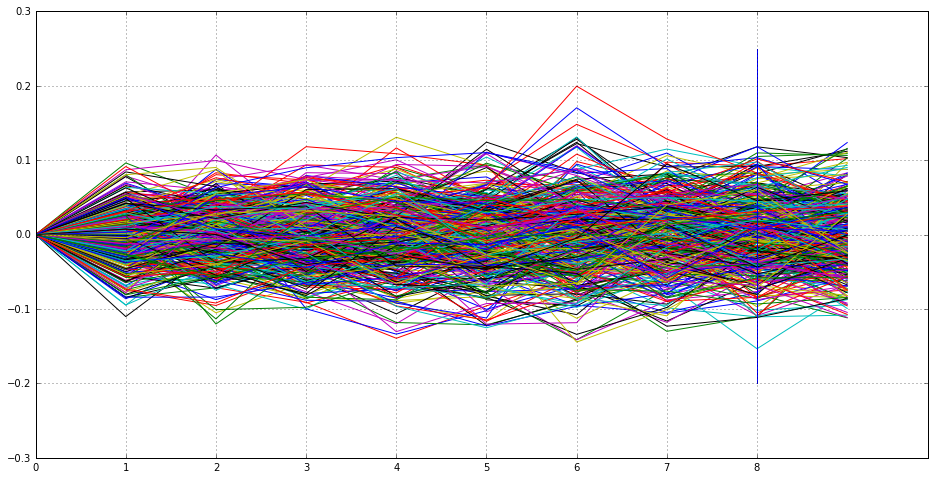

In [28]:
#visualize untrained network performance (which is mostly random)
env.load_random_batch(train_attrs,train_cats,1)
display_sessions(with_plots=True)

# Training loop

In [29]:
#tools for model persistence (in progress now. Requires unique names)
from agentnet.utils.persistence import save,load
import os

In [30]:
from agentnet.display import Metrics
score_log = Metrics()

In [31]:
#starting epoch
epoch_counter = 1

#moving average estimation
alpha = 0.1
ma_reward_current = -7.
ma_reward_greedy = -7.

epoch 1000,loss 1.73174, epsilon 0.90960, rewards: ( e-greedy -7.05520, greedy -3.61421) 
rec 1.470 reg 0.262
Learning curves:


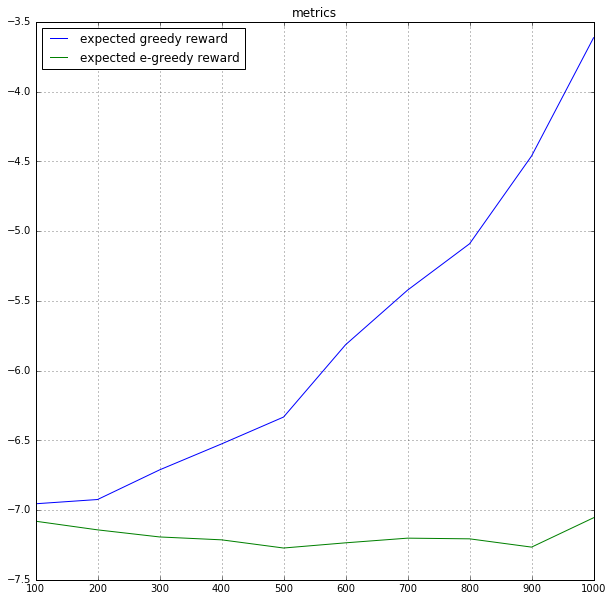

Random session examples
epoch 1100,loss 1.52471, epsilon 0.90104, rewards: ( e-greedy -6.94968, greedy -3.25279) 
rec 1.263 reg 0.262
epoch 1200,loss 1.48059, epsilon 0.89257, rewards: ( e-greedy -6.91471, greedy -2.92751) 
rec 1.218 reg 0.262
epoch 1300,loss 1.88067, epsilon 0.88419, rewards: ( e-greedy -6.80324, greedy -2.63476) 
rec 1.618 reg 0.263
epoch 1400,loss 2.03390, epsilon 0.87589, rewards: ( e-greedy -6.45292, greedy -2.37128) 
rec 1.771 reg 0.263
epoch 1500,loss 1.95750, epsilon 0.86767, rewards: ( e-greedy -6.36763, greedy -2.13415) 
rec 1.694 reg 0.263
epoch 1600,loss 2.09886, epsilon 0.85954, rewards: ( e-greedy -5.92086, greedy -1.92074) 
rec 1.836 reg 0.263
epoch 1700,loss 2.32517, epsilon 0.85148, rewards: ( e-greedy -5.62878, greedy -1.72867) 
rec 2.062 reg 0.263
epoch 1800,loss 2.60676, epsilon 0.84351, rewards: ( e-greedy -5.53590, greedy -1.55580) 
rec 2.343 reg 0.263
epoch 1900,loss 2.73229, epsilon 0.83561, rewards: ( e-greedy -5.32231, greedy -1.40022) 
rec 2.

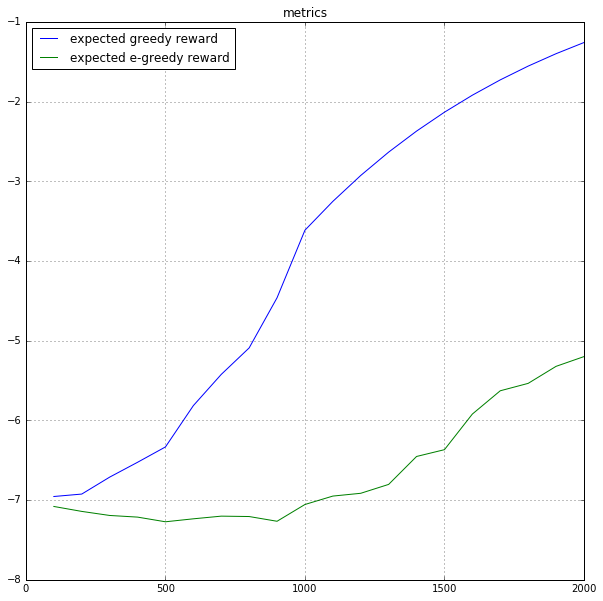

Random session examples
epoch 2100,loss 2.47835, epsilon 0.82006, rewards: ( e-greedy -4.87007, greedy -1.13418) 
rec 2.215 reg 0.264
epoch 2200,loss 2.63668, epsilon 0.81239, rewards: ( e-greedy -4.50306, greedy -1.02076) 
rec 2.373 reg 0.264
epoch 2300,loss 2.69478, epsilon 0.80481, rewards: ( e-greedy -4.31276, greedy -0.91868) 
rec 2.431 reg 0.264
epoch 2400,loss 2.71071, epsilon 0.79730, rewards: ( e-greedy -4.14648, greedy -0.82682) 
rec 2.447 reg 0.264
epoch 2500,loss 2.36583, epsilon 0.78986, rewards: ( e-greedy -3.93183, greedy -0.74413) 
rec 2.102 reg 0.264
epoch 2600,loss 3.12370, epsilon 0.78250, rewards: ( e-greedy -3.78865, greedy -0.66972) 
rec 2.860 reg 0.264
epoch 2700,loss 2.34818, epsilon 0.77521, rewards: ( e-greedy -3.76978, greedy -0.60275) 
rec 2.085 reg 0.264
epoch 2800,loss 2.47775, epsilon 0.76799, rewards: ( e-greedy -3.58281, greedy -0.54247) 
rec 2.214 reg 0.263
epoch 2900,loss 1.56847, epsilon 0.76085, rewards: ( e-greedy -3.42453, greedy -0.48823) 
rec 1.

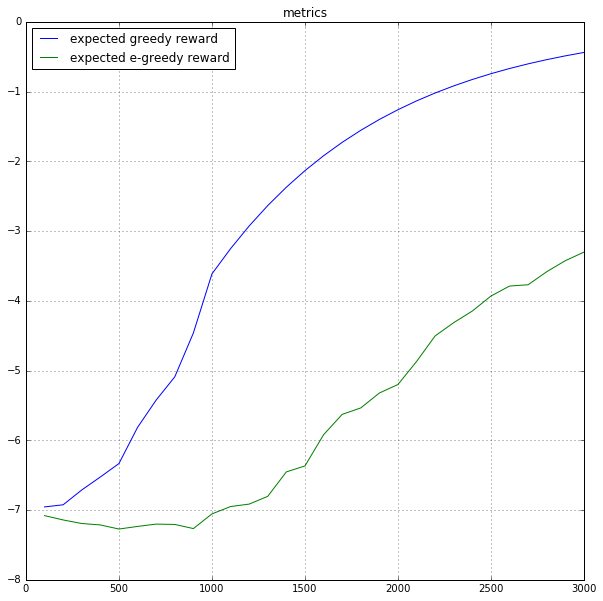

Random session examples
epoch 3100,loss 2.59182, epsilon 0.74677, rewards: ( e-greedy -3.08187, greedy -0.39546) 
rec 2.329 reg 0.263
epoch 3200,loss 2.47539, epsilon 0.73984, rewards: ( e-greedy -3.00868, greedy -0.35592) 
rec 2.213 reg 0.263
epoch 3300,loss 3.05879, epsilon 0.73298, rewards: ( e-greedy -2.88781, greedy -0.32033) 
rec 2.796 reg 0.263
epoch 3400,loss 2.40911, epsilon 0.72618, rewards: ( e-greedy -2.77903, greedy -0.28829) 
rec 2.147 reg 0.262
epoch 3500,loss 2.55273, epsilon 0.71945, rewards: ( e-greedy -2.70113, greedy -0.25946) 
rec 2.291 reg 0.262
epoch 3600,loss 2.74094, epsilon 0.71279, rewards: ( e-greedy -2.74101, greedy -0.23352) 
rec 2.479 reg 0.262
epoch 3700,loss 2.65102, epsilon 0.70620, rewards: ( e-greedy -2.74691, greedy -0.21017) 
rec 2.390 reg 0.261
epoch 3800,loss 2.82722, epsilon 0.69967, rewards: ( e-greedy -2.66222, greedy -0.18915) 
rec 2.566 reg 0.261
epoch 3900,loss 2.68996, epsilon 0.69320, rewards: ( e-greedy -2.57600, greedy -0.17023) 
rec 2.

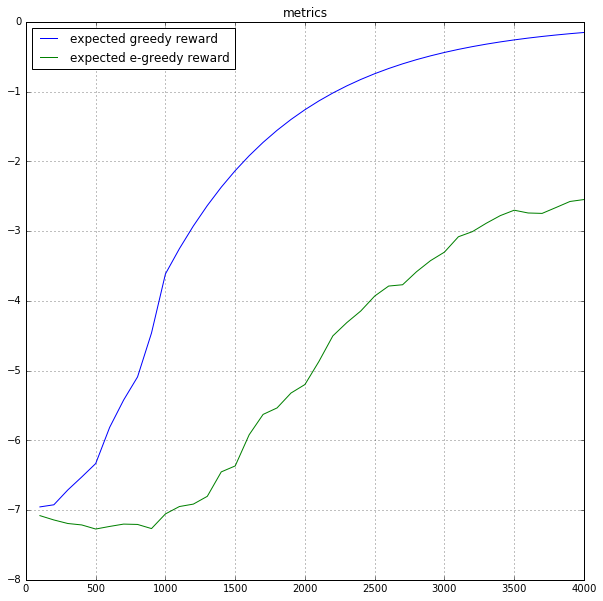

Random session examples
epoch 4100,loss 1.83399, epsilon 0.68047, rewards: ( e-greedy -2.46356, greedy -0.13789) 
rec 1.574 reg 0.260
epoch 4200,loss 2.44917, epsilon 0.67419, rewards: ( e-greedy -2.31720, greedy -0.12410) 
rec 2.189 reg 0.260
epoch 4300,loss 1.73570, epsilon 0.66798, rewards: ( e-greedy -2.30548, greedy -0.11169) 
rec 1.476 reg 0.259
epoch 4400,loss 1.84971, epsilon 0.66183, rewards: ( e-greedy -2.19493, greedy -0.10052) 
rec 1.591 reg 0.259
epoch 4500,loss 1.35392, epsilon 0.65575, rewards: ( e-greedy -2.04544, greedy -0.09047) 
rec 1.095 reg 0.259
epoch 4600,loss 2.02168, epsilon 0.64972, rewards: ( e-greedy -2.04590, greedy -0.08142) 
rec 1.763 reg 0.258
epoch 4700,loss 1.71800, epsilon 0.64375, rewards: ( e-greedy -2.11131, greedy -0.07328) 
rec 1.460 reg 0.258
epoch 4800,loss 2.17817, epsilon 0.63784, rewards: ( e-greedy -2.00018, greedy -0.06595) 
rec 1.921 reg 0.257
epoch 4900,loss 2.30840, epsilon 0.63200, rewards: ( e-greedy -1.96016, greedy -0.05936) 
rec 2.

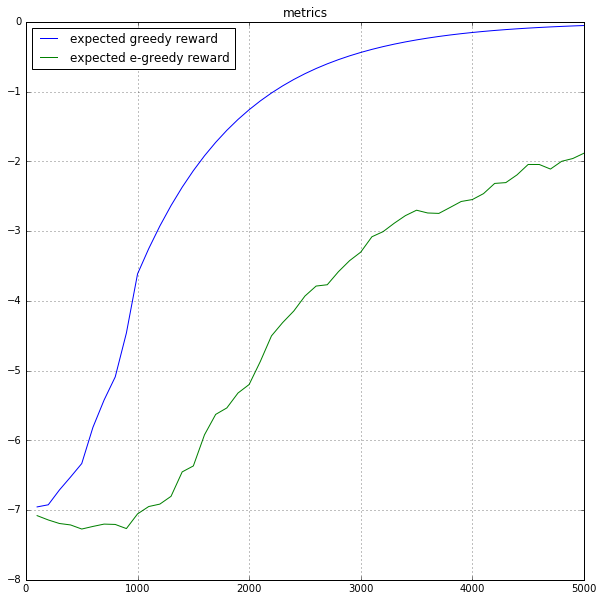

Random session examples
epoch 5100,loss 0.98635, epsilon 0.62047, rewards: ( e-greedy -1.87573, greedy -0.04808) 
rec 0.730 reg 0.256
epoch 5200,loss 1.21144, epsilon 0.61479, rewards: ( e-greedy -1.86816, greedy -0.04327) 
rec 0.956 reg 0.256
epoch 5300,loss 1.65874, epsilon 0.60917, rewards: ( e-greedy -1.79134, greedy -0.03894) 
rec 1.404 reg 0.255
epoch 5400,loss 2.01143, epsilon 0.60361, rewards: ( e-greedy -1.70221, greedy -0.03505) 
rec 1.757 reg 0.255
epoch 5500,loss 1.65734, epsilon 0.59810, rewards: ( e-greedy -1.64199, greedy -0.03154) 
rec 1.403 reg 0.254
epoch 5600,loss 1.14510, epsilon 0.59265, rewards: ( e-greedy -1.55779, greedy -0.02839) 
rec 0.891 reg 0.254
epoch 5700,loss 0.95238, epsilon 0.58725, rewards: ( e-greedy -1.55201, greedy -0.02555) 
rec 0.699 reg 0.253
epoch 5800,loss 1.74821, epsilon 0.58190, rewards: ( e-greedy -1.50681, greedy -0.02300) 
rec 1.495 reg 0.253
epoch 5900,loss 1.39179, epsilon 0.57661, rewards: ( e-greedy -1.38613, greedy -0.02070) 
rec 1.

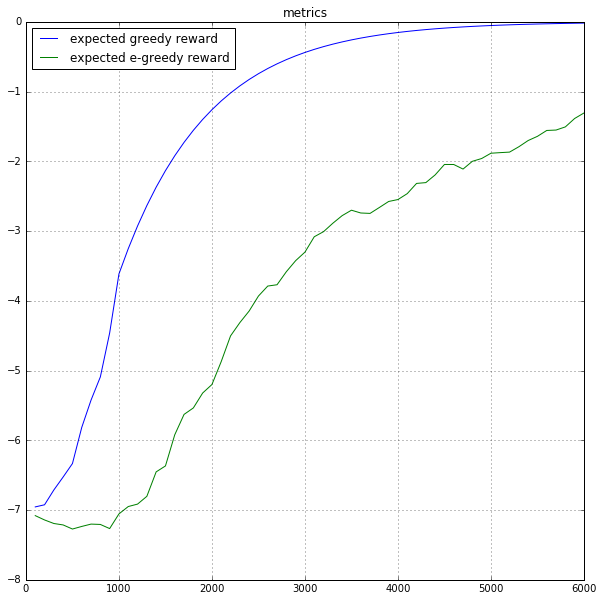

Random session examples
epoch 6100,loss 1.51471, epsilon 0.56618, rewards: ( e-greedy -1.36676, greedy -0.01676) 
rec 1.263 reg 0.252
epoch 6200,loss 1.01216, epsilon 0.56105, rewards: ( e-greedy -1.31009, greedy -0.01509) 
rec 0.761 reg 0.251
epoch 6300,loss 1.27543, epsilon 0.55596, rewards: ( e-greedy -1.28908, greedy -0.01358) 
rec 1.025 reg 0.251
epoch 6400,loss 1.34814, epsilon 0.55093, rewards: ( e-greedy -1.31017, greedy -0.01222) 
rec 1.098 reg 0.250
epoch 6500,loss 0.85455, epsilon 0.54594, rewards: ( e-greedy -1.30915, greedy -0.01100) 
rec 0.605 reg 0.250
epoch 6600,loss 1.10953, epsilon 0.54101, rewards: ( e-greedy -1.30824, greedy -0.00990) 
rec 0.860 reg 0.249
epoch 6700,loss 0.95000, epsilon 0.53612, rewards: ( e-greedy -1.24741, greedy -0.00891) 
rec 0.701 reg 0.249
epoch 6800,loss 0.79964, epsilon 0.53129, rewards: ( e-greedy -1.15267, greedy -0.00802) 
rec 0.551 reg 0.248
epoch 6900,loss 1.45935, epsilon 0.52650, rewards: ( e-greedy -1.13241, greedy -0.00722) 
rec 1.

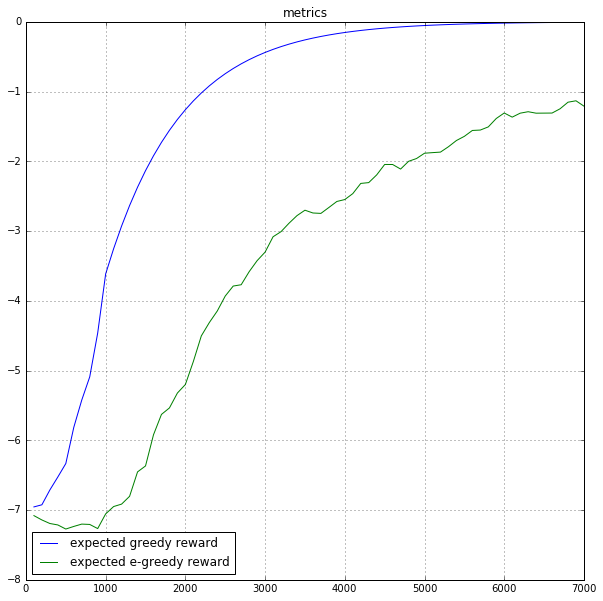

Random session examples
epoch 7100,loss 1.14170, epsilon 0.51706, rewards: ( e-greedy -1.19825, greedy -0.00585) 
rec 0.895 reg 0.247
epoch 7200,loss 0.81184, epsilon 0.51241, rewards: ( e-greedy -1.21842, greedy -0.00526) 
rec 0.565 reg 0.246
epoch 7300,loss 0.98699, epsilon 0.50781, rewards: ( e-greedy -1.15658, greedy -0.00473) 
rec 0.741 reg 0.246
epoch 7400,loss 1.49063, epsilon 0.50326, rewards: ( e-greedy -1.10092, greedy -0.00426) 
rec 1.245 reg 0.245
epoch 7500,loss 0.71357, epsilon 0.49875, rewards: ( e-greedy -1.09083, greedy -0.00384) 
rec 0.469 reg 0.245
epoch 7600,loss 0.65274, epsilon 0.49428, rewards: ( e-greedy -1.04175, greedy -0.00345) 
rec 0.409 reg 0.244
epoch 7700,loss 0.64385, epsilon 0.48986, rewards: ( e-greedy -1.02757, greedy -0.00311) 
rec 0.400 reg 0.244
epoch 7800,loss 0.96214, epsilon 0.48549, rewards: ( e-greedy -1.02482, greedy -0.00280) 
rec 0.719 reg 0.243
epoch 7900,loss 0.66588, epsilon 0.48115, rewards: ( e-greedy -1.04233, greedy -0.00252) 
rec 0.

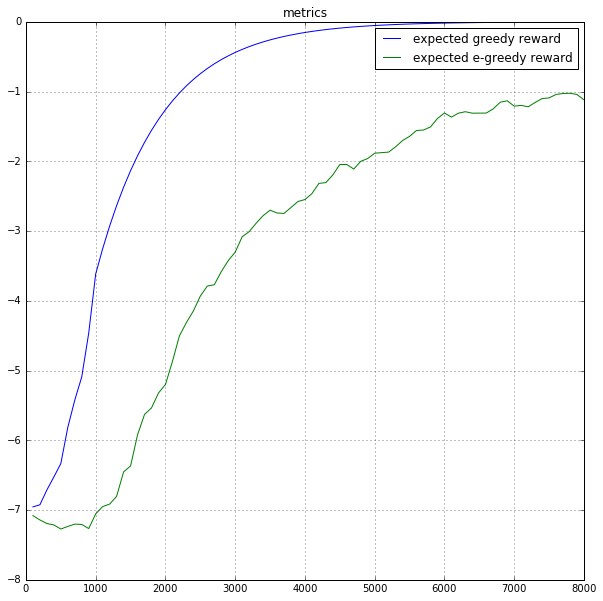

Random session examples
epoch 8100,loss 0.67665, epsilon 0.47262, rewards: ( e-greedy -1.10629, greedy -0.00204) 
rec 0.435 reg 0.241
epoch 8200,loss 0.54110, epsilon 0.46841, rewards: ( e-greedy -1.09566, greedy -0.00183) 
rec 0.300 reg 0.241
epoch 8300,loss 0.74153, epsilon 0.46425, rewards: ( e-greedy -1.02610, greedy -0.00165) 
rec 0.501 reg 0.240
epoch 8400,loss 0.47159, epsilon 0.46012, rewards: ( e-greedy -0.96349, greedy -0.00149) 
rec 0.232 reg 0.240
epoch 8500,loss 0.45626, epsilon 0.45604, rewards: ( e-greedy -0.98714, greedy -0.00134) 
rec 0.217 reg 0.239
epoch 8600,loss 0.63157, epsilon 0.45200, rewards: ( e-greedy -0.93842, greedy -0.00120) 
rec 0.393 reg 0.239
epoch 8700,loss 0.29366, epsilon 0.44800, rewards: ( e-greedy -0.88458, greedy -0.00108) 
rec 0.055 reg 0.238
epoch 8800,loss 0.55283, epsilon 0.44404, rewards: ( e-greedy -0.86612, greedy -0.00097) 
rec 0.315 reg 0.238
epoch 8900,loss 0.52630, epsilon 0.44012, rewards: ( e-greedy -0.80951, greedy -0.00088) 
rec 0.

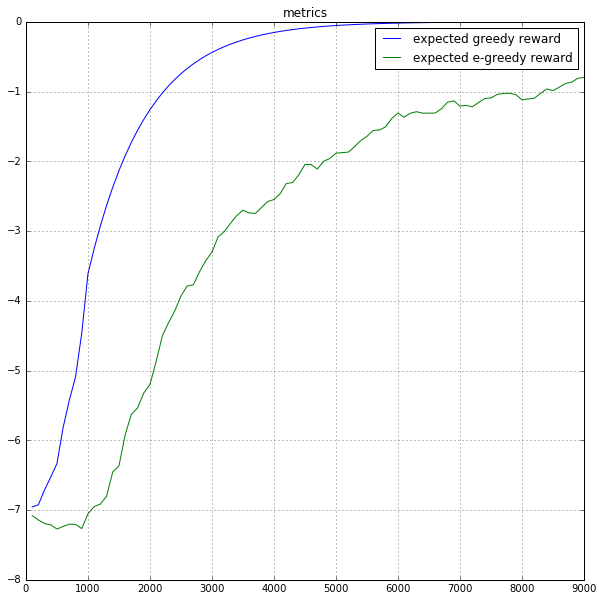

Random session examples
epoch 9100,loss 1.67822, epsilon 0.43240, rewards: ( e-greedy -0.78870, greedy -0.00071) 
rec 1.442 reg 0.236
epoch 9200,loss 0.63800, epsilon 0.42859, rewards: ( e-greedy -0.76983, greedy -0.00064) 
rec 0.402 reg 0.236
epoch 9300,loss 0.50096, epsilon 0.42483, rewards: ( e-greedy -0.79285, greedy -0.00058) 
rec 0.266 reg 0.235
epoch 9400,loss 0.51145, epsilon 0.42110, rewards: ( e-greedy -0.79357, greedy -0.00052) 
rec 0.277 reg 0.235
epoch 9500,loss 0.52393, epsilon 0.41740, rewards: ( e-greedy -0.79421, greedy -0.00047) 
rec 0.290 reg 0.234
epoch 9600,loss 0.33643, epsilon 0.41375, rewards: ( e-greedy -0.72479, greedy -0.00042) 
rec 0.103 reg 0.234
epoch 9700,loss 0.34545, epsilon 0.41013, rewards: ( e-greedy -0.80731, greedy -0.00038) 
rec 0.112 reg 0.233
epoch 9800,loss 0.31173, epsilon 0.40655, rewards: ( e-greedy -0.84658, greedy -0.00034) 
rec 0.079 reg 0.233
epoch 9900,loss 0.40229, epsilon 0.40300, rewards: ( e-greedy -0.81192, greedy -0.00031) 
rec 0.

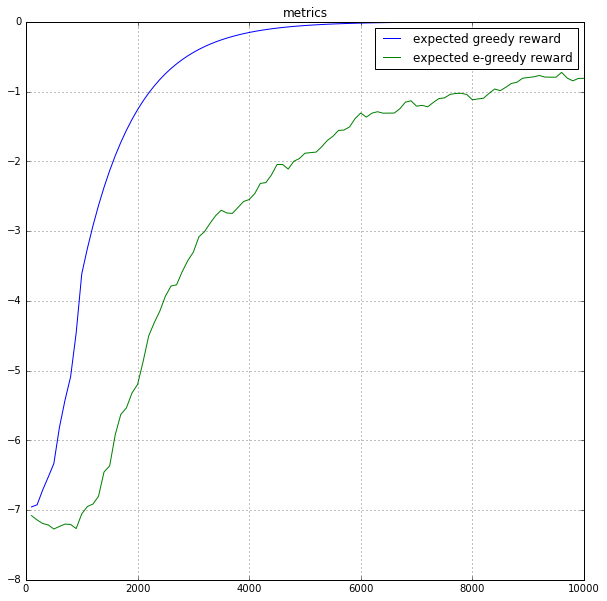

Random session examples
saved /home/jheuristic/yozhik/agentnet_snapshots/tutorial.wikicat.advanced.sessions-debug.epoch10000.pcl
epoch 10100,loss 0.24308, epsilon 0.39601, rewards: ( e-greedy -0.75966, greedy -0.00025) 
rec 0.012 reg 0.231
epoch 10200,loss 0.26817, epsilon 0.39257, rewards: ( e-greedy -0.81369, greedy -0.00022) 
rec 0.037 reg 0.231
epoch 10300,loss 0.48462, epsilon 0.38916, rewards: ( e-greedy -0.75232, greedy -0.00020) 
rec 0.254 reg 0.230
epoch 10400,loss 0.57017, epsilon 0.38578, rewards: ( e-greedy -0.70709, greedy -0.00018) 
rec 0.340 reg 0.230
epoch 10500,loss 0.44505, epsilon 0.38244, rewards: ( e-greedy -0.70638, greedy -0.00016) 
rec 0.215 reg 0.230
epoch 10600,loss 0.41048, epsilon 0.37913, rewards: ( e-greedy -0.72574, greedy -0.00015) 
rec 0.181 reg 0.229
epoch 10700,loss 0.48932, epsilon 0.37586, rewards: ( e-greedy -0.70317, greedy -0.00013) 
rec 0.261 reg 0.229
epoch 10800,loss 0.44125, epsilon 0.37262, rewards: ( e-greedy -0.67285, greedy -0.00012) 
rec

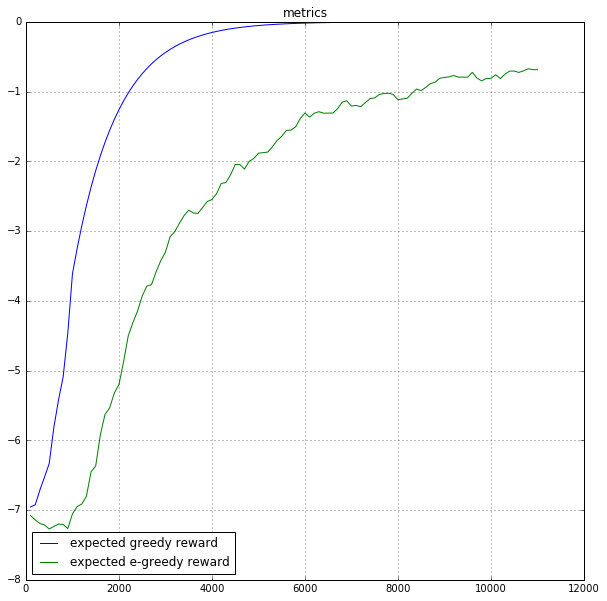

Random session examples
epoch 11100,loss 0.24985, epsilon 0.36308, rewards: ( e-greedy -0.63831, greedy -0.00009) 
rec 0.023 reg 0.227
epoch 11200,loss 0.25781, epsilon 0.35997, rewards: ( e-greedy -0.59448, greedy -0.00008) 
rec 0.031 reg 0.226
epoch 11300,loss 0.46214, epsilon 0.35688, rewards: ( e-greedy -0.58503, greedy -0.00007) 
rec 0.236 reg 0.226
epoch 11400,loss 0.31058, epsilon 0.35383, rewards: ( e-greedy -0.58653, greedy -0.00006) 
rec 0.085 reg 0.225
epoch 11500,loss 0.76685, epsilon 0.35080, rewards: ( e-greedy -0.58787, greedy -0.00006) 
rec 0.542 reg 0.225
epoch 11600,loss 0.51783, epsilon 0.34781, rewards: ( e-greedy -0.60909, greedy -0.00005) 
rec 0.293 reg 0.225
epoch 11700,loss 0.40197, epsilon 0.34485, rewards: ( e-greedy -0.64318, greedy -0.00005) 
rec 0.178 reg 0.224
epoch 11800,loss 0.51325, epsilon 0.34191, rewards: ( e-greedy -0.61886, greedy -0.00004) 
rec 0.290 reg 0.224
epoch 11900,loss 0.45817, epsilon 0.33901, rewards: ( e-greedy -0.63697, greedy -0.00004

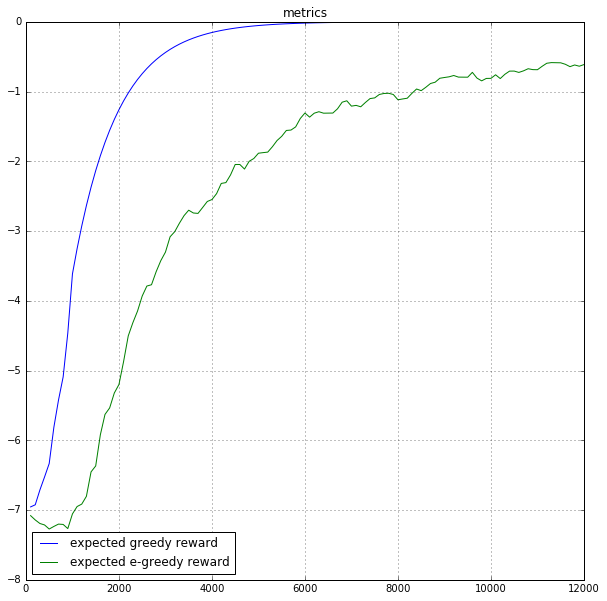

Random session examples
epoch 12100,loss 0.39738, epsilon 0.33329, rewards: ( e-greedy -0.57195, greedy -0.00003) 
rec 0.175 reg 0.222
epoch 12200,loss 0.55524, epsilon 0.33047, rewards: ( e-greedy -0.52475, greedy -0.00003) 
rec 0.333 reg 0.222
epoch 12300,loss 0.63087, epsilon 0.32768, rewards: ( e-greedy -0.47228, greedy -0.00002) 
rec 0.409 reg 0.221
epoch 12400,loss 0.63043, epsilon 0.32492, rewards: ( e-greedy -0.48505, greedy -0.00002) 
rec 0.409 reg 0.221
epoch 12500,loss 0.80889, epsilon 0.32218, rewards: ( e-greedy -0.49655, greedy -0.00002) 
rec 0.588 reg 0.221
epoch 12600,loss 0.48175, epsilon 0.31947, rewards: ( e-greedy -0.43689, greedy -0.00002) 
rec 0.262 reg 0.220
epoch 12700,loss 0.52682, epsilon 0.31679, rewards: ( e-greedy -0.43320, greedy -0.00002) 
rec 0.307 reg 0.220
epoch 12800,loss 0.48972, epsilon 0.31414, rewards: ( e-greedy -0.32988, greedy 0.09999) 
rec 0.270 reg 0.219
epoch 12900,loss 0.76572, epsilon 0.31151, rewards: ( e-greedy -0.33689, greedy 0.11999) 

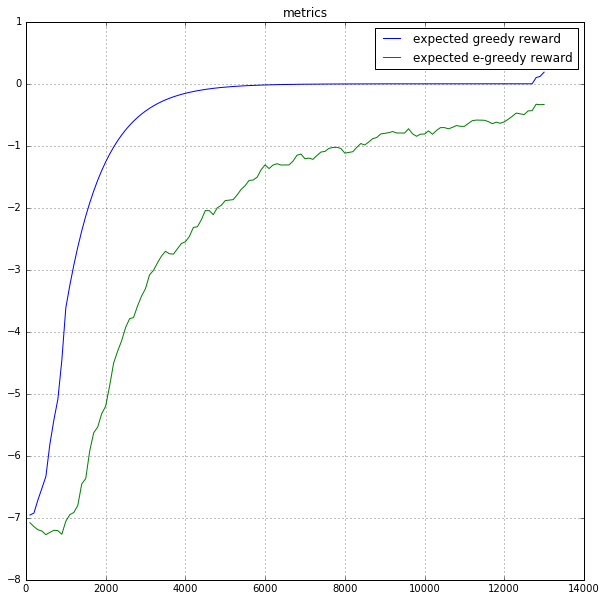

Random session examples
epoch 13100,loss 0.65391, epsilon 0.30633, rewards: ( e-greedy -0.33488, greedy 0.24419) 
rec 0.436 reg 0.218
epoch 13200,loss 1.07867, epsilon 0.30378, rewards: ( e-greedy -0.30140, greedy 0.25977) 
rec 0.861 reg 0.218
epoch 13300,loss 0.50003, epsilon 0.30125, rewards: ( e-greedy -0.27126, greedy 0.31379) 
rec 0.283 reg 0.217
epoch 13400,loss 0.45789, epsilon 0.29875, rewards: ( e-greedy -0.24413, greedy 0.38241) 
rec 0.241 reg 0.217
epoch 13500,loss 0.73995, epsilon 0.29628, rewards: ( e-greedy -0.22972, greedy 0.42417) 
rec 0.524 reg 0.216
epoch 13600,loss 0.38254, epsilon 0.29383, rewards: ( e-greedy -0.19675, greedy 0.46176) 
rec 0.167 reg 0.216
epoch 13700,loss 0.69114, epsilon 0.29140, rewards: ( e-greedy -0.16707, greedy 0.51558) 
rec 0.476 reg 0.216
epoch 13800,loss 0.65285, epsilon 0.28900, rewards: ( e-greedy -0.17036, greedy 0.52402) 
rec 0.438 reg 0.215
epoch 13900,loss 0.43005, epsilon 0.28662, rewards: ( e-greedy -0.07333, greedy 0.57162) 
rec 0.

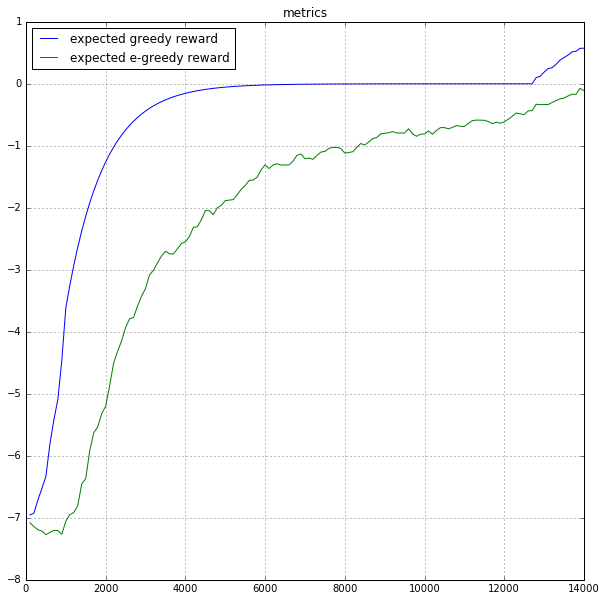

Random session examples
epoch 14100,loss 0.73468, epsilon 0.28194, rewards: ( e-greedy -0.14990, greedy 0.63701) 
rec 0.521 reg 0.214
epoch 14200,loss 0.62877, epsilon 0.27963, rewards: ( e-greedy -0.12491, greedy 0.76331) 
rec 0.415 reg 0.213
epoch 14300,loss 0.88476, epsilon 0.27734, rewards: ( e-greedy -0.13742, greedy 0.83198) 
rec 0.672 reg 0.213
epoch 14400,loss 0.85185, epsilon 0.27508, rewards: ( e-greedy -0.05367, greedy 0.94878) 
rec 0.639 reg 0.213
epoch 14500,loss 0.65748, epsilon 0.27284, rewards: ( e-greedy 0.03169, greedy 1.09390) 
rec 0.445 reg 0.212
epoch 14600,loss 0.80631, epsilon 0.27062, rewards: ( e-greedy 0.10852, greedy 1.24451) 
rec 0.595 reg 0.212
epoch 14700,loss 0.98584, epsilon 0.26843, rewards: ( e-greedy 0.04267, greedy 1.11006) 
rec 0.774 reg 0.211
epoch 14800,loss 1.02086, epsilon 0.26626, rewards: ( e-greedy -0.12160, greedy 1.10906) 
rec 0.810 reg 0.211
epoch 14900,loss 0.91817, epsilon 0.26410, rewards: ( e-greedy -0.13944, greedy 1.13815) 
rec 0.708

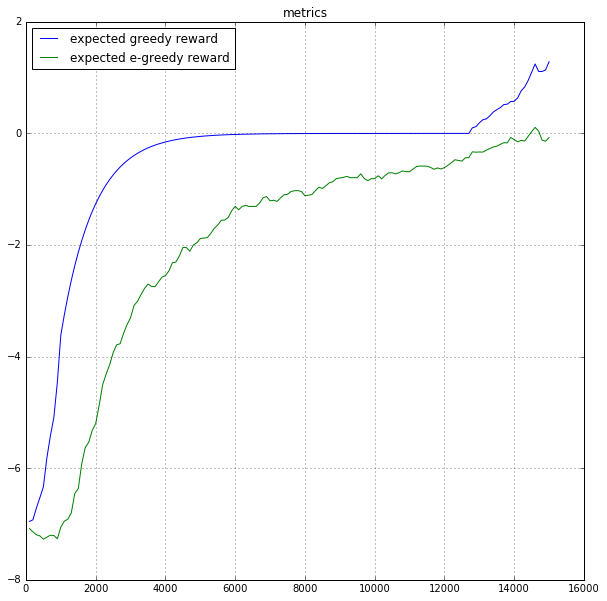

Random session examples
epoch 15100,loss 0.81906, epsilon 0.25986, rewards: ( e-greedy -0.07294, greedy 1.26590) 
rec 0.609 reg 0.210
epoch 15200,loss 1.06961, epsilon 0.25778, rewards: ( e-greedy -0.01065, greedy 1.31931) 
rec 0.860 reg 0.209
epoch 15300,loss 0.87956, epsilon 0.25571, rewards: ( e-greedy -0.13958, greedy 1.22738) 
rec 0.671 reg 0.209
epoch 15400,loss 1.04873, epsilon 0.25366, rewards: ( e-greedy -0.25563, greedy 1.19464) 
rec 0.840 reg 0.209
epoch 15500,loss 1.19835, epsilon 0.25164, rewards: ( e-greedy -0.25506, greedy 1.28018) 
rec 0.990 reg 0.208
epoch 15600,loss 0.94725, epsilon 0.24963, rewards: ( e-greedy -0.21956, greedy 1.28216) 
rec 0.740 reg 0.208
epoch 15700,loss 1.16599, epsilon 0.24764, rewards: ( e-greedy -0.17760, greedy 1.28894) 
rec 0.959 reg 0.207
epoch 15800,loss 0.73059, epsilon 0.24568, rewards: ( e-greedy -0.12484, greedy 1.37505) 
rec 0.524 reg 0.207
epoch 15900,loss 0.82233, epsilon 0.24373, rewards: ( e-greedy 0.00764, greedy 1.49754) 
rec 0.6

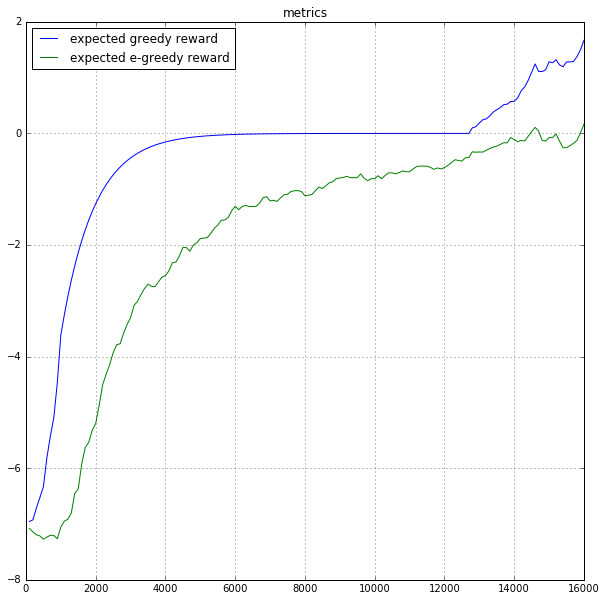

Random session examples
epoch 16100,loss 0.81487, epsilon 0.23989, rewards: ( e-greedy 0.16019, greedy 1.70101) 
rec 0.609 reg 0.206
epoch 16200,loss 0.75646, epsilon 0.23800, rewards: ( e-greedy 0.25417, greedy 1.81091) 
rec 0.551 reg 0.205
epoch 16300,loss 0.98616, epsilon 0.23613, rewards: ( e-greedy 0.30875, greedy 1.90482) 
rec 0.781 reg 0.205
epoch 16400,loss 1.01289, epsilon 0.23428, rewards: ( e-greedy 0.31788, greedy 1.87434) 
rec 0.808 reg 0.205
epoch 16500,loss 1.07228, epsilon 0.23245, rewards: ( e-greedy 0.23609, greedy 1.79690) 
rec 0.868 reg 0.204
epoch 16600,loss 1.35184, epsilon 0.23063, rewards: ( e-greedy 0.13248, greedy 1.66221) 
rec 1.148 reg 0.204
epoch 16700,loss 0.82064, epsilon 0.22883, rewards: ( e-greedy 0.20923, greedy 1.71599) 
rec 0.617 reg 0.203
epoch 16800,loss 0.82244, epsilon 0.22706, rewards: ( e-greedy 0.27831, greedy 1.74439) 
rec 0.619 reg 0.203
epoch 16900,loss 0.87456, epsilon 0.22529, rewards: ( e-greedy 0.33048, greedy 1.83495) 
rec 0.672 reg 0

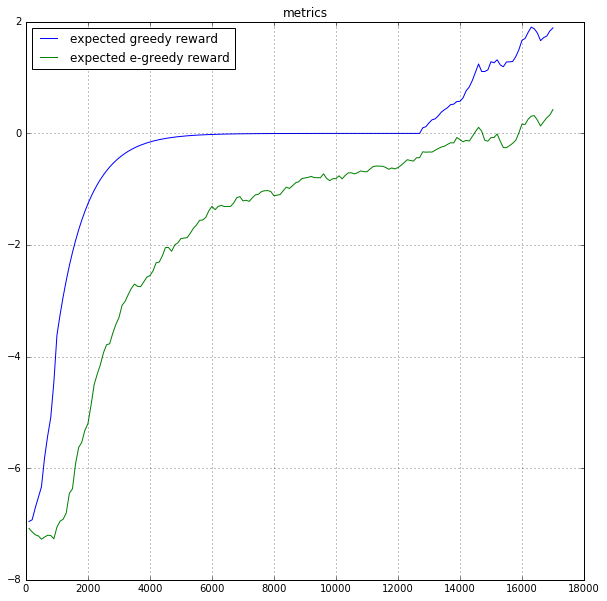

Random session examples
epoch 17100,loss 1.34589, epsilon 0.22182, rewards: ( e-greedy 0.33969, greedy 1.82231) 
rec 1.144 reg 0.202
epoch 17200,loss 1.10031, epsilon 0.22011, rewards: ( e-greedy 0.38572, greedy 1.82008) 
rec 0.899 reg 0.201
epoch 17300,loss 0.96856, epsilon 0.21842, rewards: ( e-greedy 0.46715, greedy 1.79807) 
rec 0.767 reg 0.201
epoch 17400,loss 1.05978, epsilon 0.21674, rewards: ( e-greedy 0.42043, greedy 1.71827) 
rec 0.859 reg 0.201
epoch 17500,loss 0.63467, epsilon 0.21509, rewards: ( e-greedy 0.55839, greedy 1.84644) 
rec 0.434 reg 0.200
epoch 17600,loss 1.15569, epsilon 0.21344, rewards: ( e-greedy 0.66255, greedy 1.89180) 
rec 0.956 reg 0.200
epoch 17700,loss 0.67535, epsilon 0.21182, rewards: ( e-greedy 0.71630, greedy 1.92262) 
rec 0.476 reg 0.200
epoch 17800,loss 0.73423, epsilon 0.21021, rewards: ( e-greedy 0.81467, greedy 2.03535) 
rec 0.535 reg 0.199
epoch 17900,loss 0.71261, epsilon 0.20861, rewards: ( e-greedy 0.80820, greedy 2.13682) 
rec 0.514 reg 0

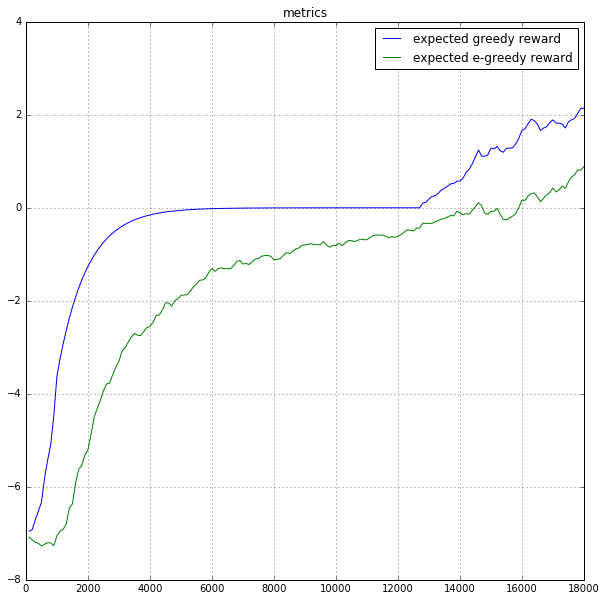

Random session examples
epoch 18100,loss 0.93843, epsilon 0.20547, rewards: ( e-greedy 0.88364, greedy 2.14382) 
rec 0.740 reg 0.198
epoch 18200,loss 0.93757, epsilon 0.20392, rewards: ( e-greedy 0.83028, greedy 2.08444) 
rec 0.740 reg 0.198
epoch 18300,loss 0.88498, epsilon 0.20239, rewards: ( e-greedy 0.73225, greedy 2.05100) 
rec 0.688 reg 0.197
epoch 18400,loss 0.79264, epsilon 0.20088, rewards: ( e-greedy 0.76902, greedy 2.05590) 
rec 0.596 reg 0.197
epoch 18500,loss 0.61864, epsilon 0.19938, rewards: ( e-greedy 0.78212, greedy 2.09031) 
rec 0.422 reg 0.196
epoch 18600,loss 0.80062, epsilon 0.19789, rewards: ( e-greedy 0.82391, greedy 2.16628) 
rec 0.605 reg 0.196
epoch 18700,loss 0.70351, epsilon 0.19642, rewards: ( e-greedy 0.79152, greedy 2.22965) 
rec 0.508 reg 0.196
epoch 18800,loss 0.89676, epsilon 0.19496, rewards: ( e-greedy 0.78237, greedy 2.16668) 
rec 0.701 reg 0.195
epoch 18900,loss 0.66114, epsilon 0.19352, rewards: ( e-greedy 0.73913, greedy 2.19502) 
rec 0.466 reg 0

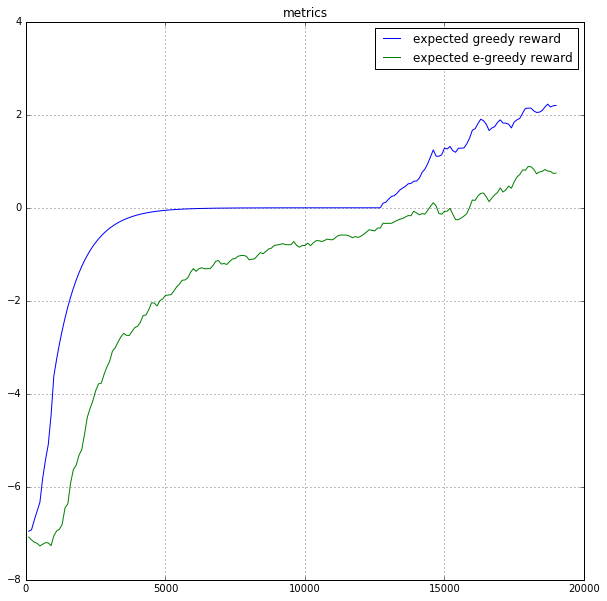

Random session examples
epoch 19100,loss 0.73120, epsilon 0.19068, rewards: ( e-greedy 0.72070, greedy 2.20046) 
rec 0.537 reg 0.194
epoch 19200,loss 1.02489, epsilon 0.18928, rewards: ( e-greedy 0.71863, greedy 2.22042) 
rec 0.831 reg 0.194
epoch 19300,loss 1.00935, epsilon 0.18789, rewards: ( e-greedy 0.73176, greedy 2.17837) 
rec 0.816 reg 0.194
epoch 19400,loss 0.75450, epsilon 0.18652, rewards: ( e-greedy 0.84359, greedy 2.18554) 
rec 0.561 reg 0.193
epoch 19500,loss 1.05167, epsilon 0.18516, rewards: ( e-greedy 0.86923, greedy 2.15698) 
rec 0.859 reg 0.193
epoch 19600,loss 0.91181, epsilon 0.18382, rewards: ( e-greedy 0.77731, greedy 2.12629) 
rec 0.719 reg 0.192
epoch 19700,loss 0.79342, epsilon 0.18248, rewards: ( e-greedy 0.86958, greedy 2.18366) 
rec 0.601 reg 0.192
epoch 19800,loss 0.76633, epsilon 0.18117, rewards: ( e-greedy 0.88262, greedy 2.20529) 
rec 0.575 reg 0.192
epoch 19900,loss 1.08870, epsilon 0.17986, rewards: ( e-greedy 0.95436, greedy 2.25476) 
rec 0.897 reg 0

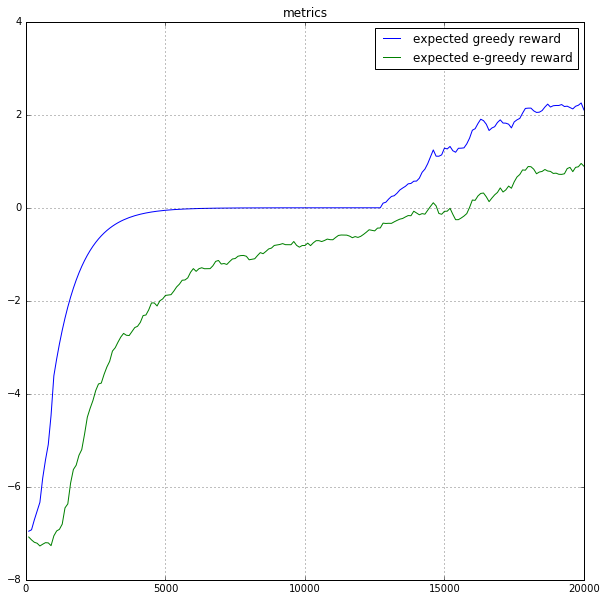

Random session examples
saved /home/jheuristic/yozhik/agentnet_snapshots/tutorial.wikicat.advanced.sessions-debug.epoch20000.pcl
epoch 20100,loss 1.11441, epsilon 0.17729, rewards: ( e-greedy 0.83453, greedy 2.04386) 
rec 0.924 reg 0.191
epoch 20200,loss 0.70657, epsilon 0.17602, rewards: ( e-greedy 0.96108, greedy 2.17947) 
rec 0.516 reg 0.190
epoch 20300,loss 0.83664, epsilon 0.17477, rewards: ( e-greedy 1.07497, greedy 2.27152) 
rec 0.647 reg 0.190
epoch 20400,loss 0.77533, epsilon 0.17353, rewards: ( e-greedy 1.20247, greedy 2.40937) 
rec 0.586 reg 0.190
epoch 20500,loss 0.82950, epsilon 0.17230, rewards: ( e-greedy 1.17722, greedy 2.37343) 
rec 0.640 reg 0.189
epoch 20600,loss 1.07709, epsilon 0.17108, rewards: ( e-greedy 1.27950, greedy 2.52609) 
rec 0.888 reg 0.189
epoch 20700,loss 0.71171, epsilon 0.16988, rewards: ( e-greedy 1.28155, greedy 2.72348) 
rec 0.523 reg 0.189
epoch 20800,loss 0.88596, epsilon 0.16868, rewards: ( e-greedy 1.40340, greedy 2.78613) 
rec 0.698 reg 0.188

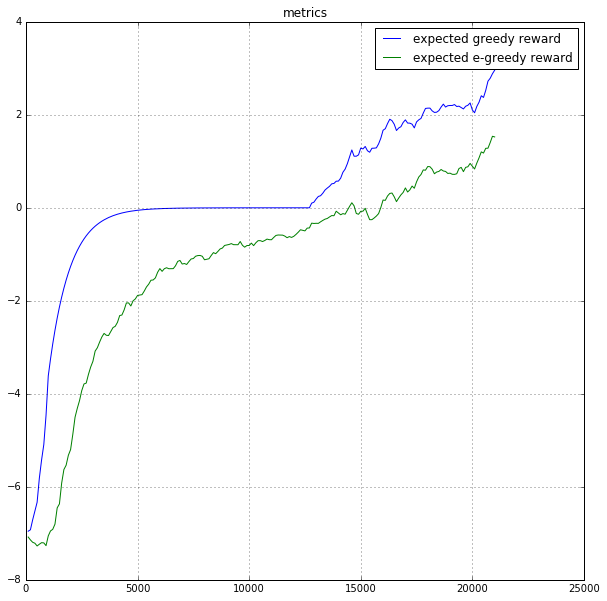

Random session examples
epoch 21100,loss 0.80088, epsilon 0.16518, rewards: ( e-greedy 1.56683, greedy 3.03834) 
rec 0.614 reg 0.187
epoch 21200,loss 0.80493, epsilon 0.16403, rewards: ( e-greedy 1.58014, greedy 3.09451) 
rec 0.618 reg 0.187
epoch 21300,loss 0.92834, epsilon 0.16290, rewards: ( e-greedy 1.68213, greedy 3.15006) 
rec 0.742 reg 0.187
epoch 21400,loss 1.13493, epsilon 0.16177, rewards: ( e-greedy 1.71392, greedy 3.20505) 
rec 0.949 reg 0.186
epoch 21500,loss 0.91154, epsilon 0.16066, rewards: ( e-greedy 1.69752, greedy 3.21455) 
rec 0.726 reg 0.186
epoch 21600,loss 0.97795, epsilon 0.15956, rewards: ( e-greedy 1.60277, greedy 3.13809) 
rec 0.792 reg 0.186
epoch 21700,loss 0.96133, epsilon 0.15847, rewards: ( e-greedy 1.62249, greedy 3.23428) 
rec 0.776 reg 0.185
epoch 21800,loss 0.87590, epsilon 0.15739, rewards: ( e-greedy 1.69525, greedy 3.32585) 
rec 0.691 reg 0.185
epoch 21900,loss 1.06424, epsilon 0.15632, rewards: ( e-greedy 1.67072, greedy 3.27327) 
rec 0.880 reg 0

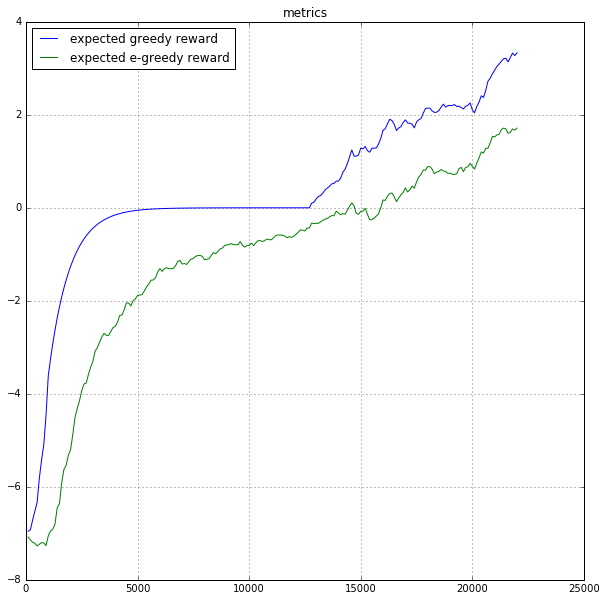

Random session examples
epoch 22100,loss 0.83518, epsilon 0.15422, rewards: ( e-greedy 1.70728, greedy 3.33285) 
rec 0.651 reg 0.184
epoch 22200,loss 1.12309, epsilon 0.15318, rewards: ( e-greedy 1.74656, greedy 3.27456) 
rec 0.939 reg 0.184
epoch 22300,loss 0.89731, epsilon 0.15215, rewards: ( e-greedy 1.77190, greedy 3.21211) 
rec 0.714 reg 0.183
epoch 22400,loss 0.69887, epsilon 0.15114, rewards: ( e-greedy 1.93471, greedy 3.39090) 
rec 0.516 reg 0.183
epoch 22500,loss 1.46432, epsilon 0.15013, rewards: ( e-greedy 1.91124, greedy 3.42681) 
rec 1.281 reg 0.183
epoch 22600,loss 0.97057, epsilon 0.14913, rewards: ( e-greedy 2.06012, greedy 3.50413) 
rec 0.788 reg 0.183
epoch 22700,loss 0.93155, epsilon 0.14815, rewards: ( e-greedy 2.13910, greedy 3.58371) 
rec 0.749 reg 0.182


In [ ]:
n_epochs = 100000
batch_size= 10

for i in range(n_epochs):    
    
    #train
    
    
    
    env.load_random_batch(train_attrs,train_cats,batch_size)
    
    load_pool_fun()
    loss,avg_reward = train_fun()
    
    
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    if epoch_counter%10 ==0:
        current_epsilon =  0.05 + 0.95*np.exp(-epoch_counter/10000.)
        resolver.epsilon.set_value(np.float32(current_epsilon))
    
    
    
    ##record current learning progress and show learning curves
    if epoch_counter%100 ==0:

        ##update learning curves
        full_loss, q_loss, l2_penalty, avg_reward_current = evaluation_fun()
        ma_reward_current = (1-alpha)*ma_reward_current + alpha*avg_reward_current
        score_log["expected e-greedy reward"][epoch_counter] = ma_reward_current
        
        
        
        #greedy train
        resolver.epsilon.set_value(0)
        avg_reward_greedy = evaluation_fun()[-1]
        ma_reward_greedy = (1-alpha)*ma_reward_greedy + alpha*avg_reward_greedy
        score_log["expected greedy reward"][epoch_counter] = ma_reward_greedy
        
        
        #back to epsilon-greedy
        resolver.epsilon.set_value(np.float32(current_epsilon))

        print "epoch %i,loss %.5f, epsilon %.5f, rewards: ( e-greedy %.5f, greedy %.5f) "%(
            epoch_counter,full_loss,current_epsilon,ma_reward_current,ma_reward_greedy)
        print "rec %.3f reg %.3f"%(q_loss,l2_penalty)

    if epoch_counter %1000 ==0:
        print "Learning curves:"
        score_log.plot()


        print "Random session examples"
        #env.load_random_batch(train_attrs,train_cats,3)
        #display_sessions(with_plots=False)
    
    #save snapshot
    if epoch_counter %10000 ==0:
        snap_name = "{}.epoch{}.pcl".format(os.path.join(snapshot_path,experiment_setup_name), epoch_counter)
        save(resolver,snap_name)
        print "saved", snap_name

        
        
    epoch_counter  +=1

    
# Time to drink some coffee!

# Evaluating results

In [ ]:
score_log.plot("final")

In [ ]:
score_log.plot("final")

In [ ]:
print "Random session examples"
env.load_random_batch(train_attrs,train_cats,10)
display_sessions(with_plots=True)


In [ ]:
#load earlier snapshot.
#warning - this overrides the latest network params with earlier ones. 
#Replace 20000 with some 100000 if you wish to load latest snapshod back.
snap_name = "{}.epoch{}.pcl".format(os.path.join(snapshot_path,experiment_setup_name), 20000)
load(resolver,snap_name)

In [ ]:
print "Random session examples"
env.load_random_batch(train_attrs,train_cats,10)
display_sessions(with_plots=True)
